## 충전소별 수요예측 및 충전패턴 분석


### 1. 읽어들일 파일명 지정 ==> 수정필요

In [1]:
# 수정필요
########### file_name 선언 ##################################
충전이력셋 = '남양주_충전이력_전처리.csv'
#############################################################

### 2. 파일읽기 - 수정 불필요

In [2]:
# 수정 불필요

import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline

#한글깨지는문제 보완
from matplotlib import font_manager,rc
font_location="c:/windows/fonts/malgun.ttf"
font_name=font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)

################## 충전이력 CSV 읽기 ####################################################
충전이력 = pd.read_csv(rf'{충전이력셋}', header=0, encoding='cp949', engine='python')
충전이력 = 충전이력.sort_values(by='충전소명')

# Null 이 있을 수 있는 칼럼은 Null을 0로 변경
충전이력.fillna(0, inplace=True)

# 문자를 date 타입으로 변환
충전이력['start'] = pd.to_datetime(충전이력['start'], format='%Y-%m-%d %H:%M:%S')
충전이력['end'] = pd.to_datetime(충전이력['end'], format='%Y-%m-%d %H:%M:%S')

print(" 총 충전소 수:", len(충전이력['충전소명'].unique()))
display(" 읽은 파일 한건만 조회", 충전이력.head(1))

################## 충전이력 CSV 읽기 끝###################################################

 총 충전소 수: 59


' 읽은 파일 한건만 조회'

,충전소명,충전기,start,end,충전량
5932,LH호평1단지,7617,2018-04-23 12:22:00,2018-04-23 12:24:00,0.2


### 3. 평균사용일수 및 사용량 계산 - 수정 불필요
- 기간(일수)를 계산 = 종료일자 - 시작일자
- 평균 사용 일수 = 총 사용횟수 / 기간(일수)
- 평균 충전량 = 총 충전량 / 기간(일수)

In [3]:
# 수정 불필요
# 시계열로 구성하기 위해 시간타입인 start를 index 칼럼으로 지정
충전이력.set_index('start', inplace=True, drop=False)

# 시작일시를 오름차 순으로 정렬 (가장 오래된 start가 맨 처음 row)
충전이력_sort = 충전이력.sort_index()

# 빈 데이터프레임 생성
result = pd.DataFrame(columns=['start', 'end', '기간(일수)','총이용수','총충전량', '일평균충전량','일평균이용수'])

# 충전소명으로 그룹핑하기 위한 사전 작업
grouped = 충전이력_sort.groupby(['충전소명'])

# 계산 시작

grouped시작일시=grouped.apply(lambda x: x.index.min())
result['start'] = grouped시작일시

grouped종료일시=grouped.apply(lambda x: x['end'].max())
result['end'] = grouped종료일시

result['총이용수'] = grouped.충전소명.count()

result['총충전량'] = grouped['충전량'].sum()

diff = result['end'] - result['start']
result['기간(일수)'] = diff.apply(lambda x: x.days+1)

result['일평균충전량'] = (result['총충전량'] / result['기간(일수)']).round(2)
result['일평균이용수'] = (result['총이용수'] / result['기간(일수)']).round(2)

result.reset_index(inplace=True)

# 최종 결과 CSV 파일쓰기
충전현황셋 = '충전량현황종합_전처리.csv'
result.to_csv(rf'{충전현황셋}', index=False, sep=',', encoding='cp949')

display ("상위권 충전소 조회", result.sort_values(by='일평균충전량', ascending=False).head(10))

'상위권 충전소 조회'

,충전소명,start,end,기간(일수),총이용수,총충전량,일평균충전량,일평균이용수
2,남양주 시청,2017-08-02 07:26:00,2018-08-01 00:20:00,364,1685,22111.55,60.75,4.63
18,롯데마트 마석점,2016-08-01 09:37:00,2018-08-01 00:08:00,730,1981,27621.51,37.84,2.71
17,롯데마트 덕소점,2018-03-22 09:59:00,2018-07-30 21:31:00,131,295,4465.01,34.08,2.25
21,별내동주민센터,2016-08-01 19:38:00,2018-07-30 13:36:00,728,1924,23846.14,32.76,2.64
41,이마트 진접점,2018-03-29 21:08:00,2018-08-31 22:49:00,156,227,4999.04,32.05,1.46
52,하나로마트 진접점,2018-03-03 12:20:00,2018-08-31 23:28:00,182,303,4813.50,26.45,1.66
29,부영2단지 아파트,2017-07-04 11:39:00,2018-09-01 00:29:00,424,671,10710.24,25.26,1.58
12,뉴욕에너지,2018-01-11 09:15:00,2018-07-28 22:14:00,199,285,4976.94,25.01,1.43
22,별내리슈빌아파트,2018-02-07 21:04:00,2018-09-01 04:23:00,206,355,4708.85,22.86,1.72
56,화도읍 공영주차장,2018-07-30 13:49:00,2018-07-30 19:53:00,1,3,22.70,22.70,3.00


### 4. 바로 위 3번 단계 실행후 아래 사항을 반드시 확인 바람
-  건건별 충전이력은 없고, 충전평균 값만 있는 충전소는 위 단계에서 write한 엑셀파일을 열어 수작업으로 추가하기 바람

### 5. 평균 값 조회 - 수정 불필요

In [4]:
# 상위권 충전소 조회

################## 최종 완성된 충전현황 CSV 읽기 ####################################################
충전현황 = pd.read_csv(f'{충전현황셋}', header=0, encoding='cp949', engine='python')
충전현황 = 충전현황.sort_values(by='충전소명')

# 일평균충전량이 Null인 것은 열외시킴
충전현황.drop(index = 충전현황[충전현황['start'].isnull()].index, inplace=True)  
display ("상위권 충전소 조회", 충전현황.sort_values(by='일평균충전량', ascending=False).head(10))

'상위권 충전소 조회'

,충전소명,start,end,기간(일수),총이용수,총충전량,일평균충전량,일평균이용수
2,남양주 시청,2017-08-02 07:26:00,2018-08-01 00:20:00,364,1685,22111.55,60.75,4.63
18,롯데마트 마석점,2016-08-01 09:37:00,2018-08-01 00:08:00,730,1981,27621.51,37.84,2.71
17,롯데마트 덕소점,2018-03-22 09:59:00,2018-07-30 21:31:00,131,295,4465.01,34.08,2.25
21,별내동주민센터,2016-08-01 19:38:00,2018-07-30 13:36:00,728,1924,23846.14,32.76,2.64
41,이마트 진접점,2018-03-29 21:08:00,2018-08-31 22:49:00,156,227,4999.04,32.05,1.46
52,하나로마트 진접점,2018-03-03 12:20:00,2018-08-31 23:28:00,182,303,4813.50,26.45,1.66
29,부영2단지 아파트,2017-07-04 11:39:00,2018-09-01 00:29:00,424,671,10710.24,25.26,1.58
12,뉴욕에너지,2018-01-11 09:15:00,2018-07-28 22:14:00,199,285,4976.94,25.01,1.43
22,별내리슈빌아파트,2018-02-07 21:04:00,2018-09-01 04:23:00,206,355,4708.85,22.86,1.72
56,화도읍 공영주차장,2018-07-30 13:49:00,2018-07-30 19:53:00,1,3,22.70,22.70,3.00


In [5]:
# 수정 불필요

#일평균충전량 순서로 sorting
display('일평균충전량 순서로 sorting', 충전현황.sort_values(by='일평균충전량', ascending=False).style.highlight_max())

#일평균이용수 순서로 sorting
display('일평균이용수 순서로 sorting', 충전현황.sort_values(by='일평균이용수', ascending=False).style.highlight_max())

'일평균충전량 순서로 sorting'

,충전소명,start,end,기간(일수),총이용수,총충전량,일평균충전량,일평균이용수
2,남양주 시청,2017-08-02 07:26:00,2018-08-01 00:20:00,364,1685,22111.5,60.75,4.63
18,롯데마트 마석점,2016-08-01 09:37:00,2018-08-01 00:08:00,730,1981,27621.5,37.84,2.71
17,롯데마트 덕소점,2018-03-22 09:59:00,2018-07-30 21:31:00,131,295,4465.01,34.08,2.25
21,별내동주민센터,2016-08-01 19:38:00,2018-07-30 13:36:00,728,1924,23846.1,32.76,2.64
41,이마트 진접점,2018-03-29 21:08:00,2018-08-31 22:49:00,156,227,4999.04,32.05,1.46
52,하나로마트 진접점,2018-03-03 12:20:00,2018-08-31 23:28:00,182,303,4813.5,26.45,1.66
29,부영2단지 아파트,2017-07-04 11:39:00,2018-09-01 00:29:00,424,671,10710.2,25.26,1.58
12,뉴욕에너지,2018-01-11 09:15:00,2018-07-28 22:14:00,199,285,4976.94,25.01,1.43
22,별내리슈빌아파트,2018-02-07 21:04:00,2018-09-01 04:23:00,206,355,4708.85,22.86,1.72
56,화도읍 공영주차장,2018-07-30 13:49:00,2018-07-30 19:53:00,1,3,22.7,22.7,3


'일평균이용수 순서로 sorting'

,충전소명,start,end,기간(일수),총이용수,총충전량,일평균충전량,일평균이용수
2,남양주 시청,2017-08-02 07:26:00,2018-08-01 00:20:00,364,1685,22111.5,60.75,4.63
56,화도읍 공영주차장,2018-07-30 13:49:00,2018-07-30 19:53:00,1,3,22.7,22.7,3
18,롯데마트 마석점,2016-08-01 09:37:00,2018-08-01 00:08:00,730,1981,27621.5,37.84,2.71
21,별내동주민센터,2016-08-01 19:38:00,2018-07-30 13:36:00,728,1924,23846.1,32.76,2.64
17,롯데마트 덕소점,2018-03-22 09:59:00,2018-07-30 21:31:00,131,295,4465.01,34.08,2.25
22,별내리슈빌아파트,2018-02-07 21:04:00,2018-09-01 04:23:00,206,355,4708.85,22.86,1.72
50,평내제2공영주차장,2018-03-30 11:01:00,2018-07-31 19:24:00,124,207,2284.93,18.43,1.67
52,하나로마트 진접점,2018-03-03 12:20:00,2018-08-31 23:28:00,182,303,4813.5,26.45,1.66
29,부영2단지 아파트,2017-07-04 11:39:00,2018-09-01 00:29:00,424,671,10710.2,25.26,1.58
41,이마트 진접점,2018-03-29 21:08:00,2018-08-31 22:49:00,156,227,4999.04,32.05,1.46


### 6. 시계열 분석

### 6.1 분석하고 싶은 충전소 갯수를 입력 - 수정 필요
- 만약 5를 입력하면 일평균충전량 상위 5개 분석할 것임

In [6]:
# 수정 필요
#상위권갯수 = 5
상위권갯수 =len(충전이력['충전소명'].unique())  # 모든 충전소를 대상으로 수행히고자 할 경우

### 6.2 시계열 분석 - 수정 불필요

,start,end,기간(일수),총이용수,총충전량,일평균충전량,일평균이용수
충전소명,,,,,,,
남양주 시청,2017-08-02 07:26:00,2018-08-01 00:20:00,364,1685,22111.550,60.75,4.63
롯데마트 마석점,2016-08-01 09:37:00,2018-08-01 00:08:00,730,1981,27621.510,37.84,2.71
롯데마트 덕소점,2018-03-22 09:59:00,2018-07-30 21:31:00,131,295,4465.010,34.08,2.25
별내동주민센터,2016-08-01 19:38:00,2018-07-30 13:36:00,728,1924,23846.140,32.76,2.64
이마트 진접점,2018-03-29 21:08:00,2018-08-31 22:49:00,156,227,4999.040,32.05,1.46
하나로마트 진접점,2018-03-03 12:20:00,2018-08-31 23:28:00,182,303,4813.500,26.45,1.66
부영2단지 아파트,2017-07-04 11:39:00,2018-09-01 00:29:00,424,671,10710.240,25.26,1.58
뉴욕에너지,2018-01-11 09:15:00,2018-07-28 22:14:00,199,285,4976.940,25.01,1.43
별내리슈빌아파트,2018-02-07 21:04:00,2018-09-01 04:23:00,206,355,4708.850,22.86,1.72


충전량 상위권 충전소명
 ['남양주 시청', '롯데마트 마석점', '롯데마트 덕소점', '별내동주민센터', '이마트 진접점', '하나로마트 진접점', '부영2단지 아파트', '뉴욕에너지', '별내리슈빌아파트', '화도읍 공영주차장', '진접센트레빌1단지', '화도효성해링턴플레이스', '힐스테이트황금산', '홈플러스 진접점', '평내제2공영주차장', '남양주시 오남읍사무소', '남양주시 진건퇴계원행정복지센터', '남양주시 오남체육문화센터', '이마트 도농점', '마석역신도브래뉴 아파트', '남양주시 진접오남행정복지센터', '진접신창비바패밀리아파트', '부영그린타운5단지', '남양주체육문화센터', '덕소두산위브 아파트', '별내우미린아파트', '별내하우스토리', '호평6단지 휴먼시아', '별내신안인스빌아파트', '덕소아이파크 아파트', '신일유토빌 아파트', '남양주시 조안면사무소', '유기농테마파크', '남양주시 이마트(남양주점)', '별내아이파크1차', '별사랑마을2-2단지', '별내 동익미라벨38단지아파트', '오남신동아아파트', '별빛마을3-5단지', '예당마을 신안인스빌아파트', '진접롯데캐슬 아파트', '사릉역노외주차장', '평내상록데시앙 아파트', '덕소건영 아파트', '남양주시 이마트(별내점)', '경복대학교 남양주캠퍼스', '진건현대아파트', 'LH호평1단지', '덕소쌍용아파트', '부영그린타운3단지', '남양주시 이마트(도농점)', '퇴계원금호어울림', '삼익파크힐스', '삼익 아파트', '진건금강아파트', '부영그린타운4단지', '호평동원로얄듀크 아파트', '평내화성파크힐즈 아파트', '평내마을 주공 아파트']


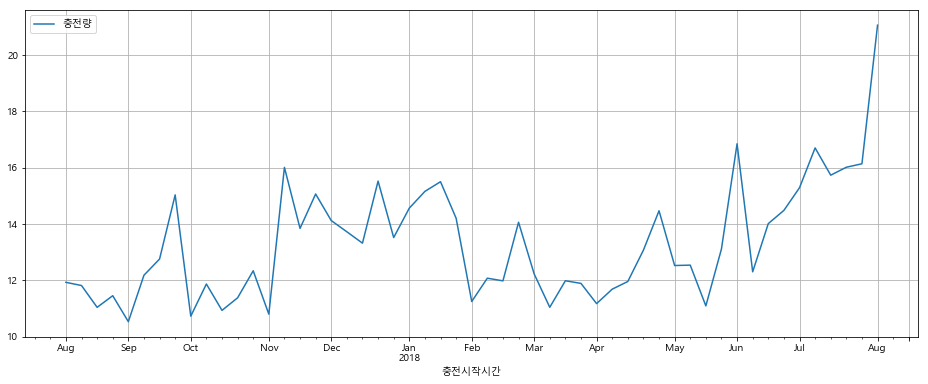

In [7]:
# 수정 불필요
# 일평균충전량 최대 조회
충전현황.set_index('충전소명', inplace=True)
상위권 = 충전현황.nlargest(상위권갯수, '일평균충전량')  # 상위권만 추출
충전현황.reset_index(inplace=True)
display(상위권)

상위권_이름 = 상위권.index.values.tolist()
print ("충전량 상위권 충전소명\n", 상위권_이름)

# 상위권 충전소만 이력 뽑기
충전상위이력 = [None] * len(상위권_이름)
for i in range(len(상위권_이름)):
    충전상위이력[i] = 충전이력[충전이력['충전소명']==상위권_이름[i]]
    

충전상위이력[0].set_index('start', drop=False, inplace=True)
충전상위이력[0]['시작연월일'] = 충전상위이력[0].index

# 그래프 가시성을 높이기 위해 weekly 충전량으로 변환
weekly_summary = pd.DataFrame()
weekly_summary['충전량'] = 충전상위이력[0]['충전량'].resample('W').mean()
weekly_summary['충전시작시간'] = weekly_summary.index
weekly_summary.plot('충전시작시간', '충전량', figsize=(16,6), grid=True);

## 7. 분석 및 예측

### 7.1 수요 패턴 분석
 - 기간동안 수요 증가 추이
 - 월별추이
 - 요일별 추이
 - 일일 추이

### 7.2 분석하고 싶은 충전소 선택 ==> 수정하세요

In [8]:
############ 수정하세요 ##########################################################################
예측하고싶은_일자 = 180                       # 60이면 향후 60일, 30이면 향후 30일
분석하고싶은충전소_갯수 = 상위권갯수   # 위 6.1에서 선언한 변수값 그대로 사용, 전체 충전소보다 같거나 작은 숫자여야 함
#################################################################################################

# 수정 불필요
print(f"분석할 일수는 향후 {예측하고싶은_일자}일 이며")
rank = 분석하고싶은충전소_갯수 - 1
충전소명 = 상위권_이름[rank]
print(f"분석할 충전소는 상위 {분석하고싶은충전소_갯수} 갯수 입니다")

분석할 일수는 향후 180일 이며
분석할 충전소는 상위 59 갯수 입니다


#### 이하 맨 끝까지 수정 불필요

### 7.3 미래수요 예측
- 1차 선형회귀를 사용하여 예측

180 일 후의 예상되는 일평균 충전량은 남양주 시청
50.01078425808308
Square Mean Error: 34.46787558244863


180 일 후의 예상되는 일평균 충전량은 롯데마트 마석점
100.99025478188867
Square Mean Error: 28.164565713693868


180 일 후의 예상되는 일평균 충전량은 롯데마트 덕소점
193.9580614423744
Square Mean Error: 27.97501915959848


180 일 후의 예상되는 일평균 충전량은 별내동주민센터
54.77450648650447
Square Mean Error: 31.356485887361945


180 일 후의 예상되는 일평균 충전량은 이마트 진접점
190.77150450706756
Square Mean Error: 29.037904842023465


180 일 후의 예상되는 일평균 충전량은 하나로마트 진접점
68.03646341159975
Square Mean Error: 28.3765641476934


180 일 후의 예상되는 일평균 충전량은 부영2단지 아파트
67.52266121094766
Square Mean Error: 22.13326945027599


180 일 후의 예상되는 일평균 충전량은 뉴욕에너지
178.4594640931934
Square Mean Error: 37.618551641067015


180 일 후의 예상되는 일평균 충전량은 별내리슈빌아파트
56.474510839536435
Square Mean Error: 16.79643597928551


충전내역 일수가 짧아 계싼 불가하여 예측을 생략합니다


180 일 후의 예상되는 일평균 충전량은 진접센트레빌1단지
91.06906906981905
Square Mean Error: 22.140680627092884


180 일 후의 예상되는 일평균 충전량은 화도효성해링턴플레이스
-11.056865342599757
Square Mean Error: 1

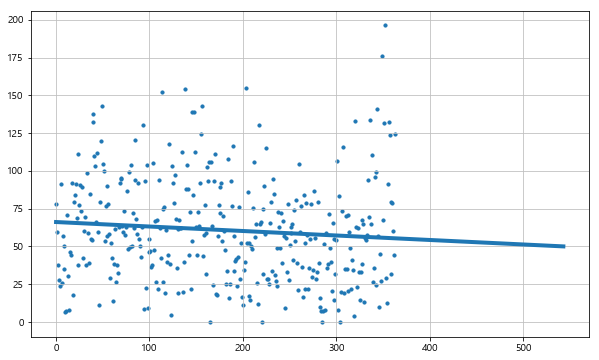

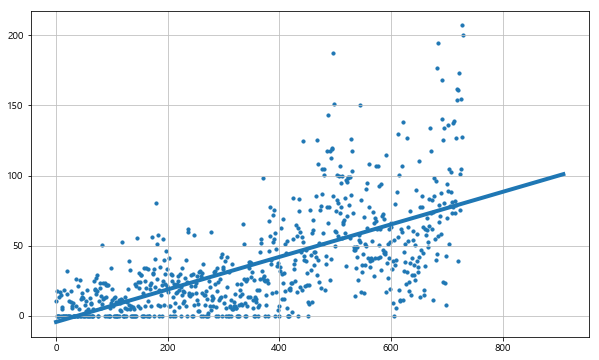

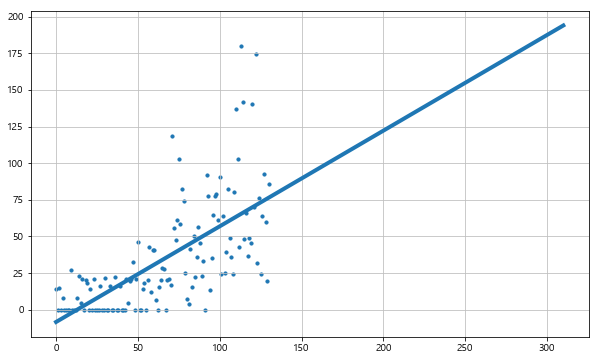

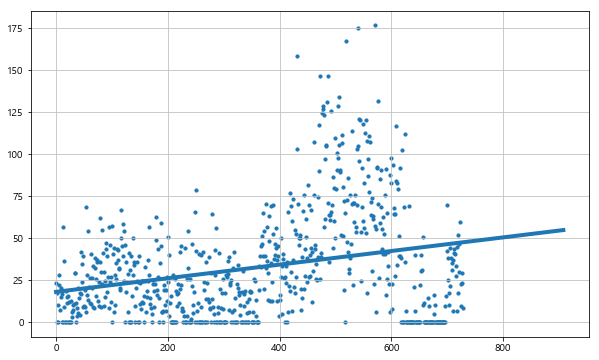

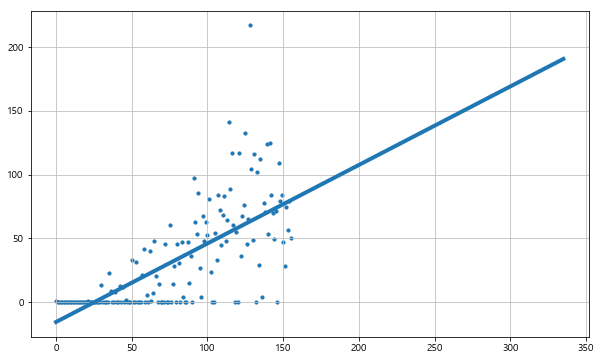

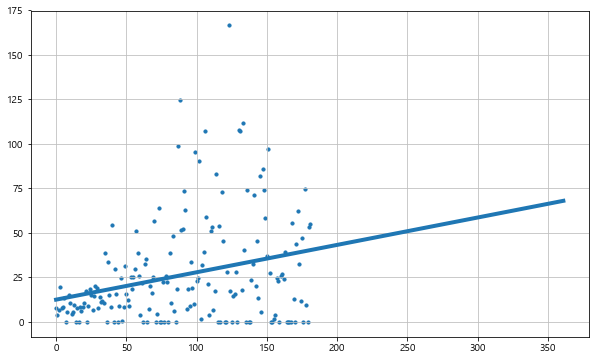

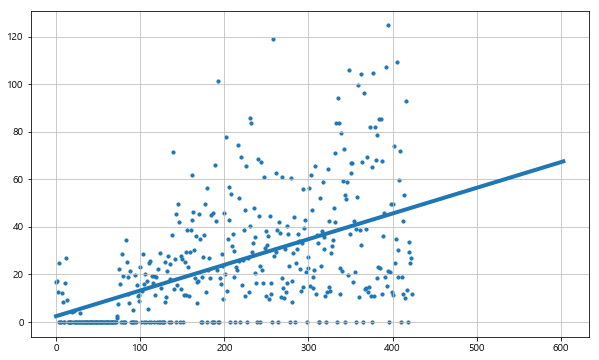

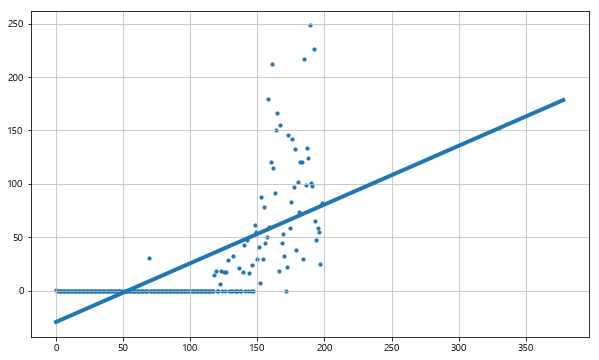

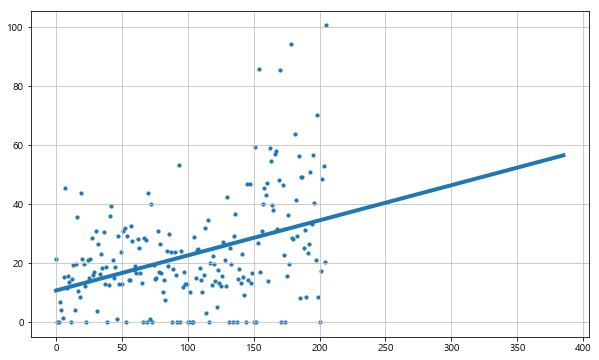

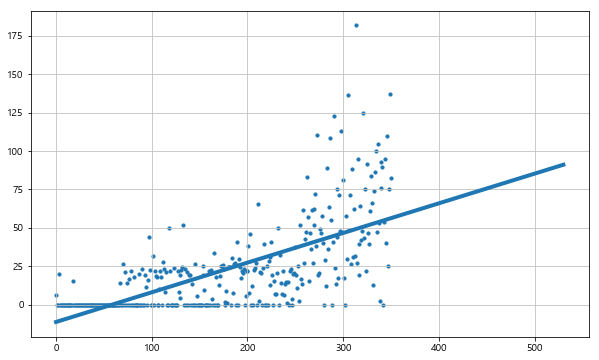

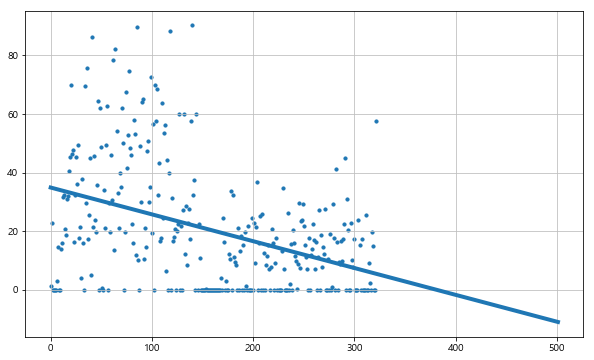

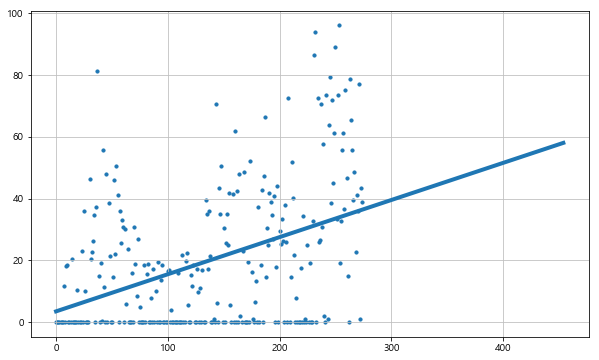

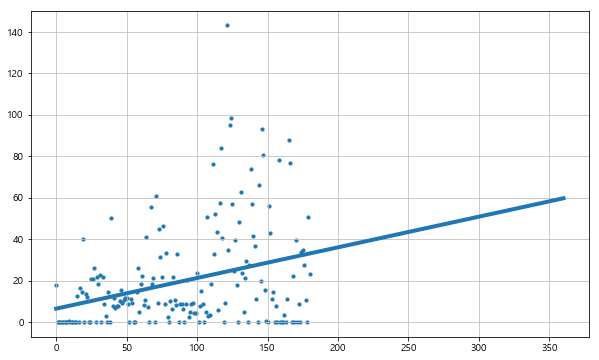

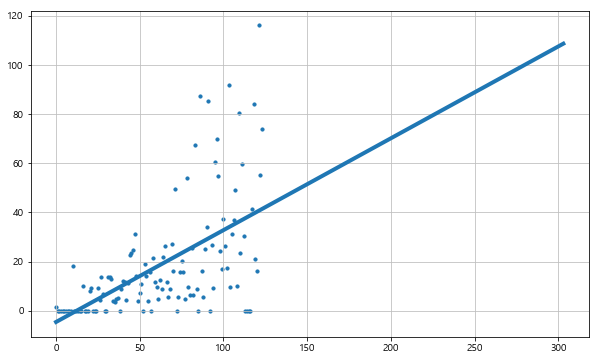

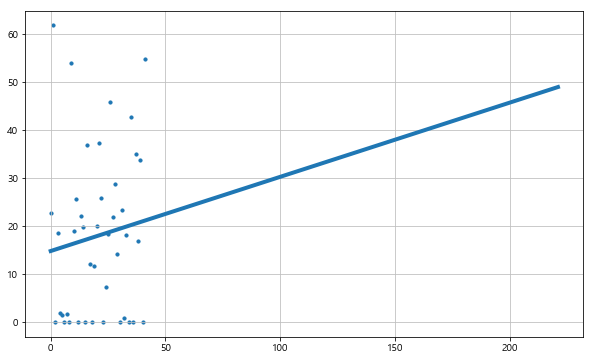

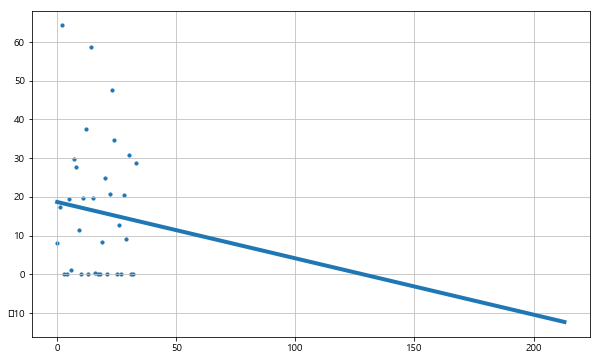

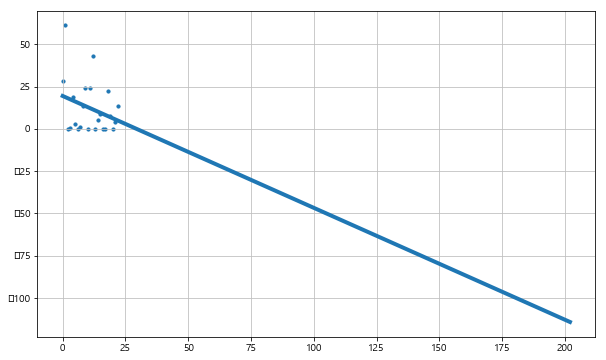

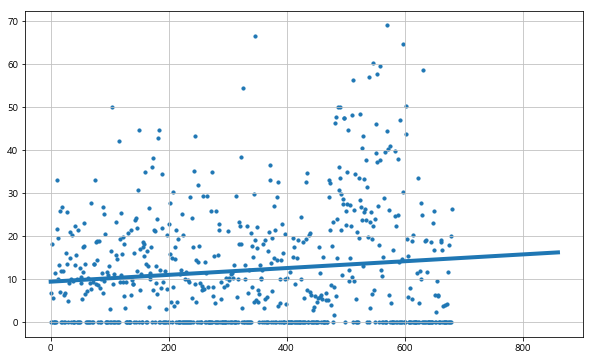

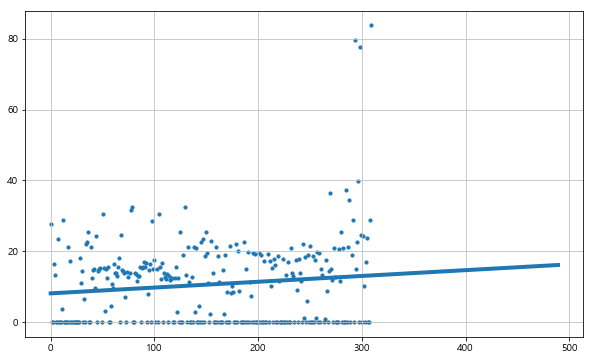

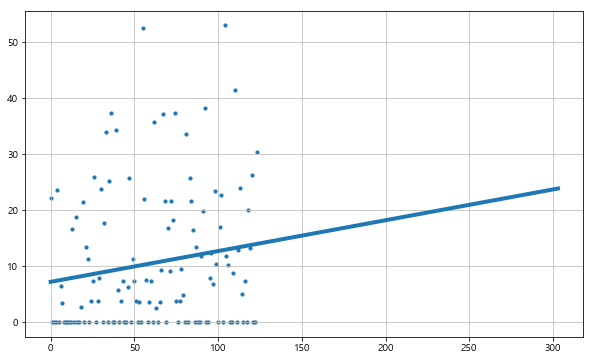

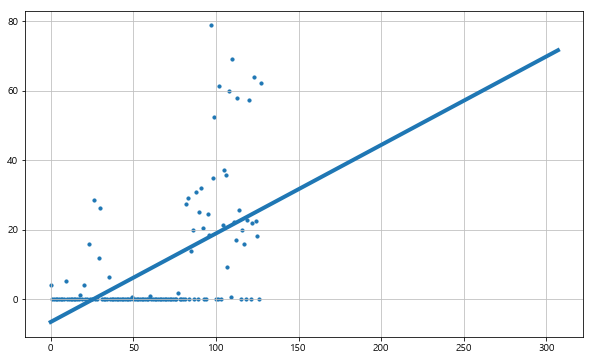

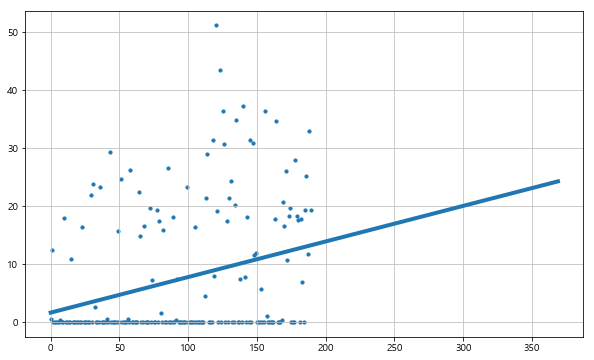

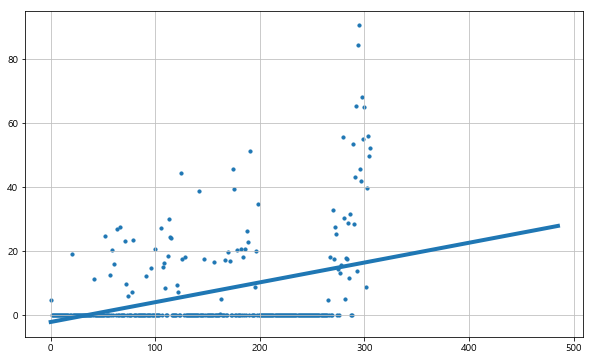

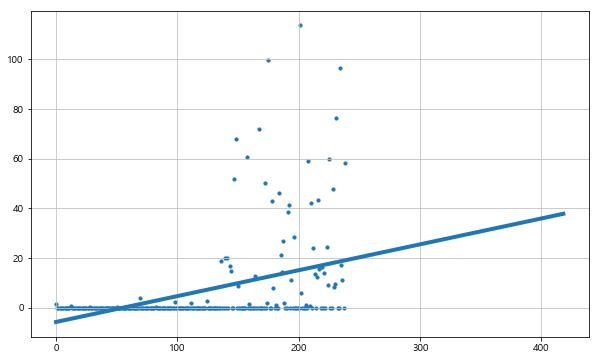

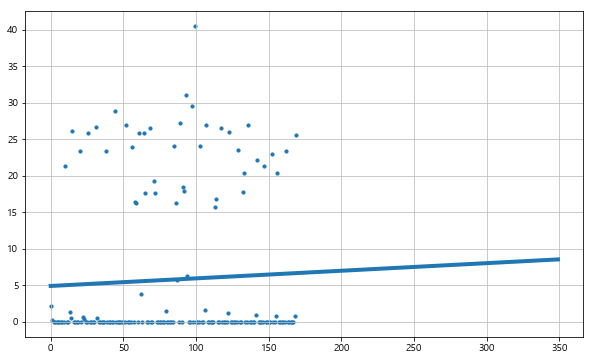

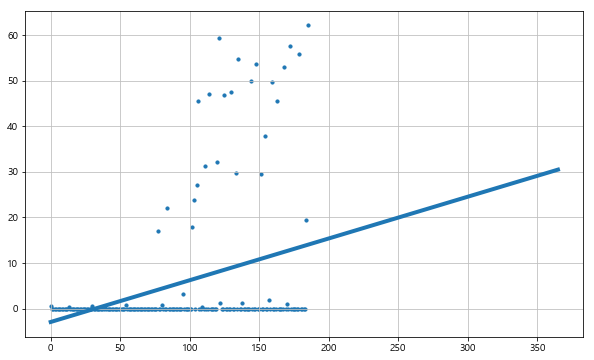

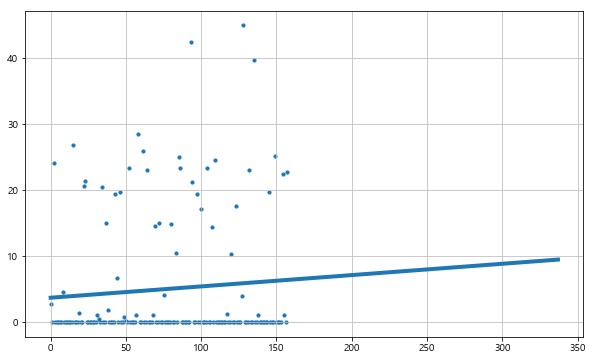

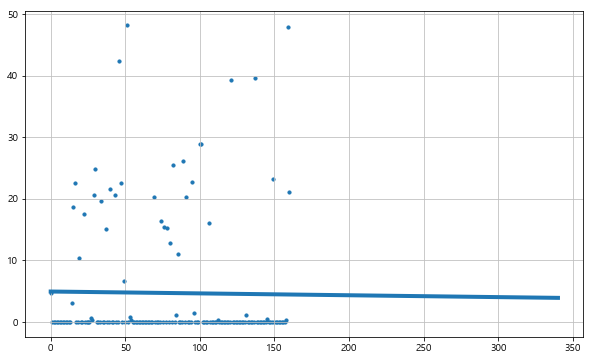

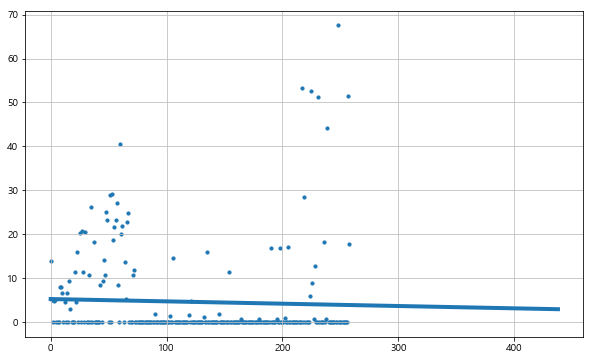

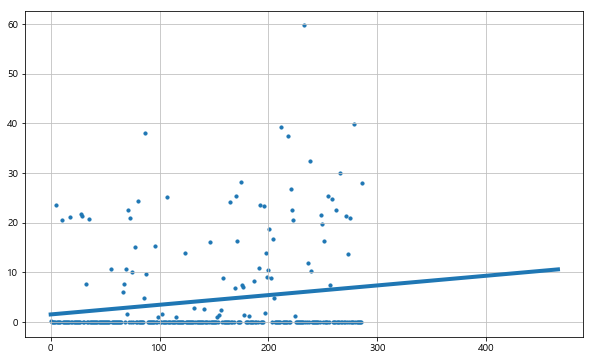

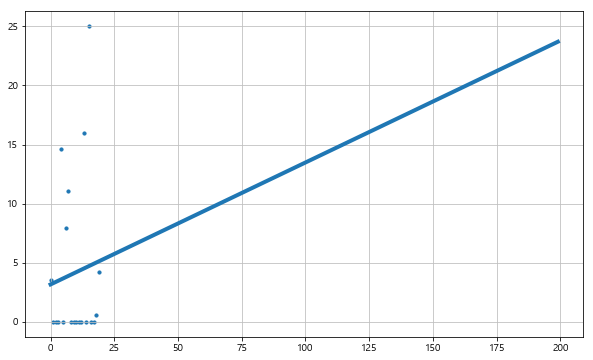

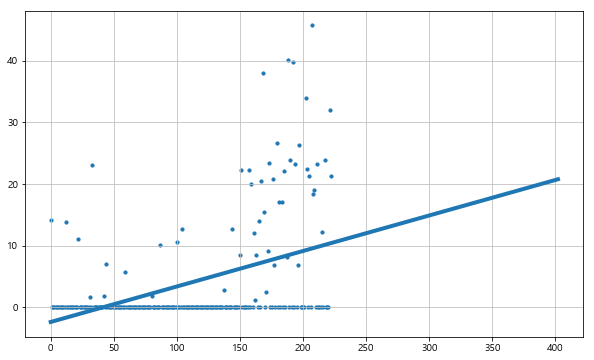

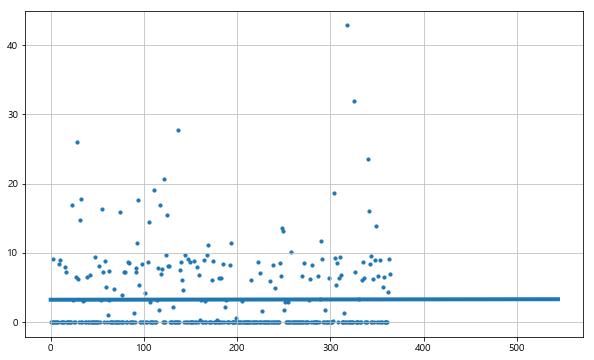

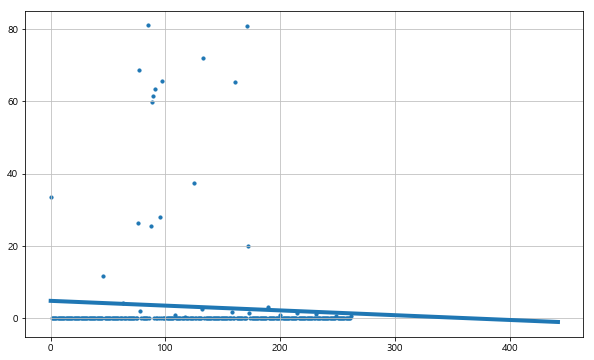

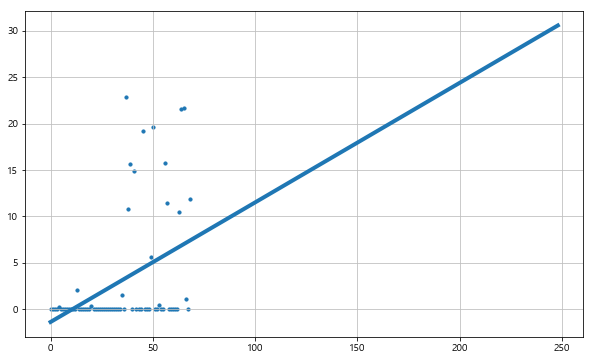

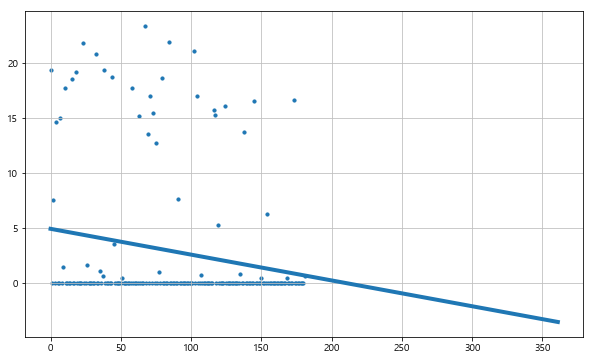

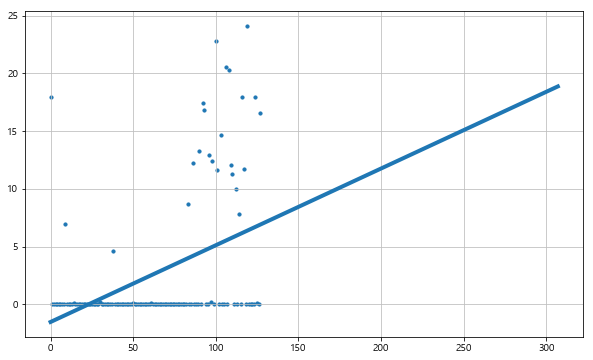

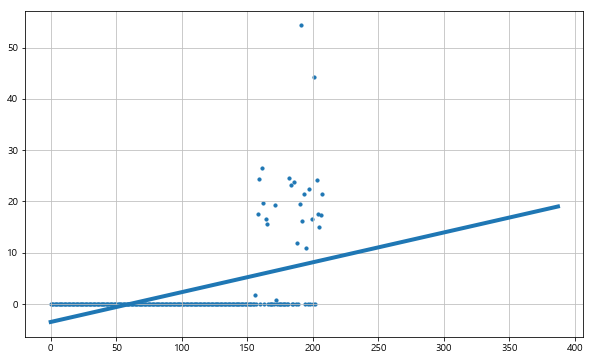

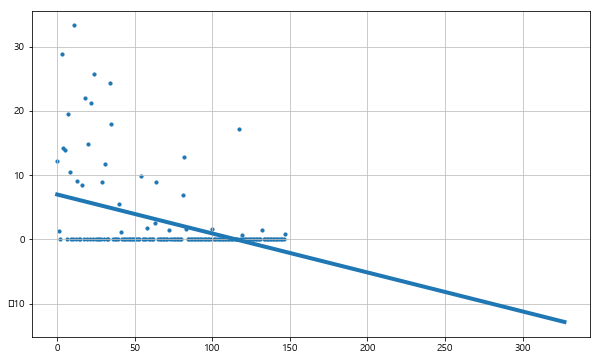

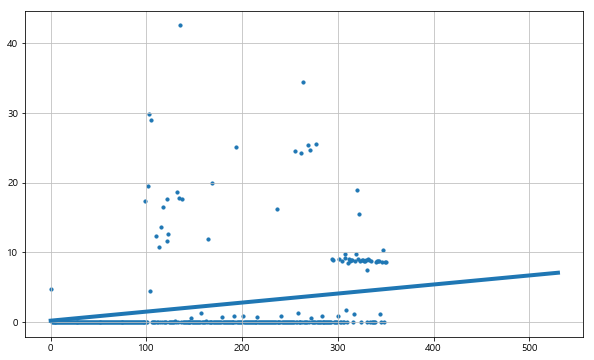

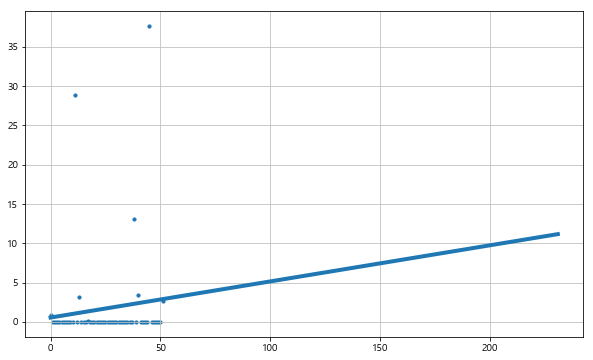

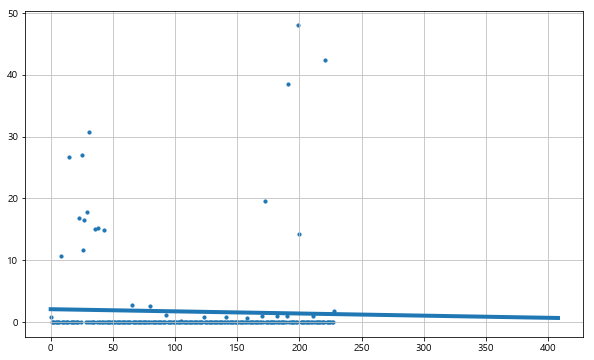

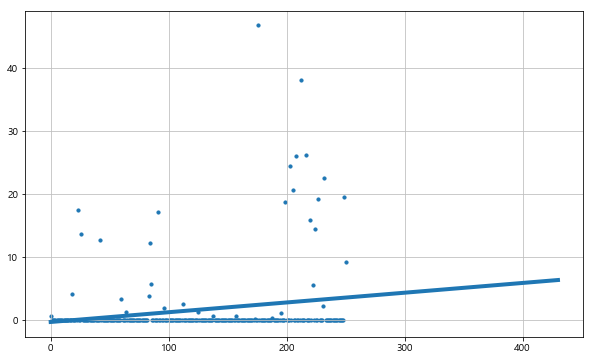

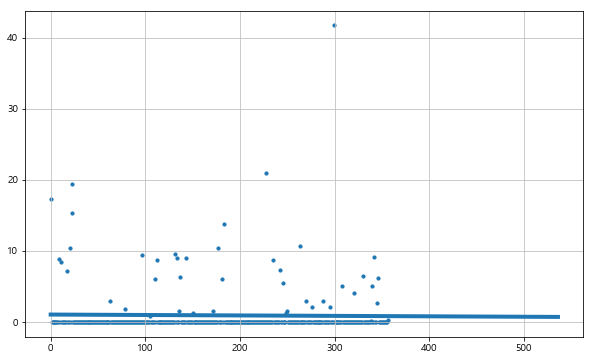

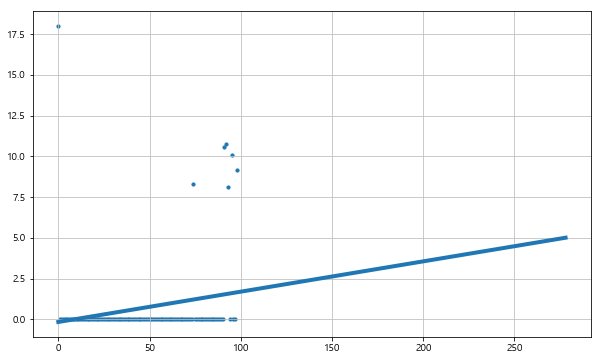

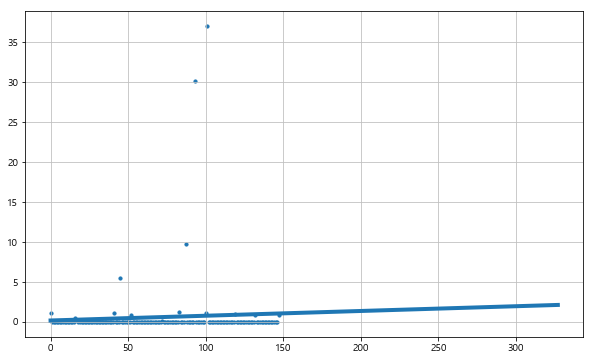

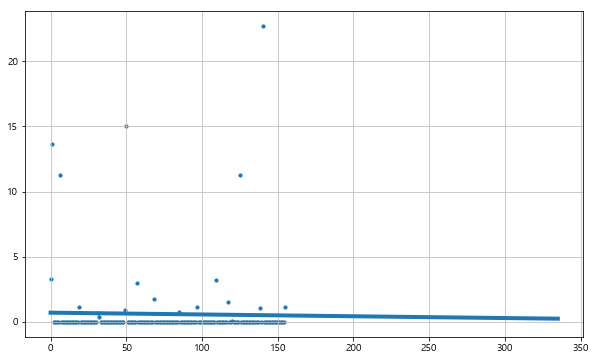

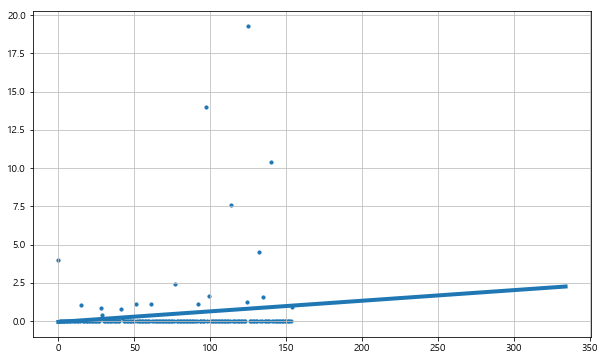

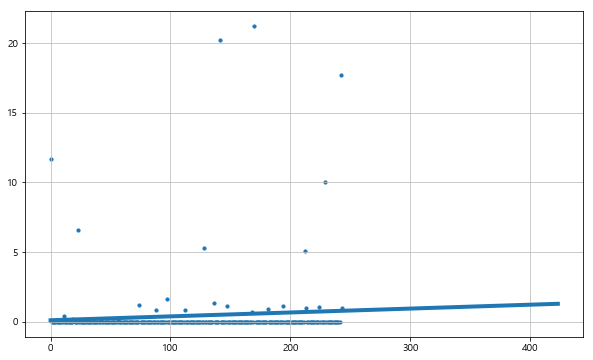

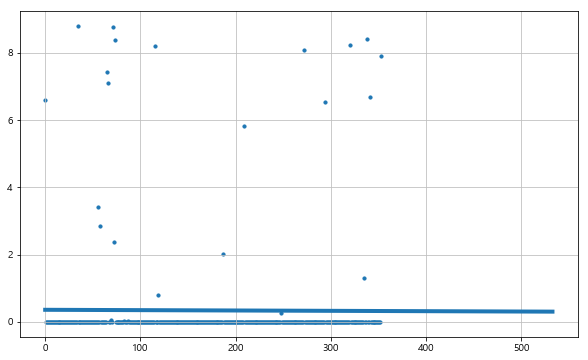

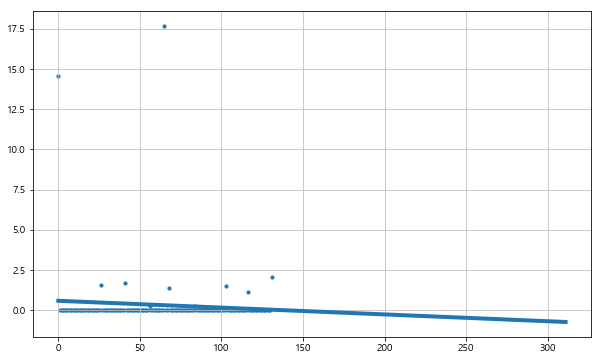

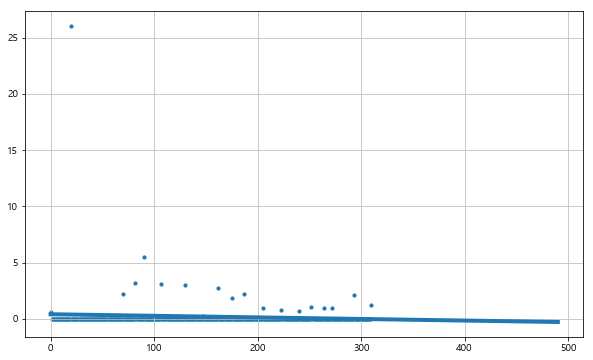

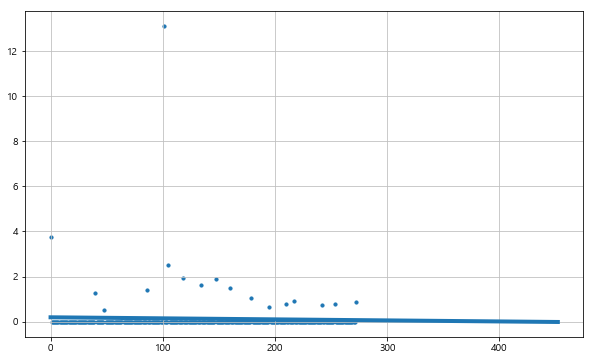

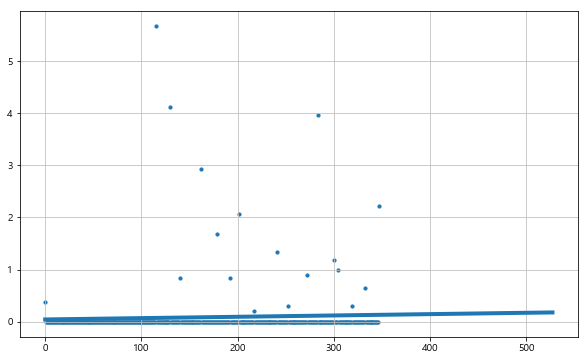

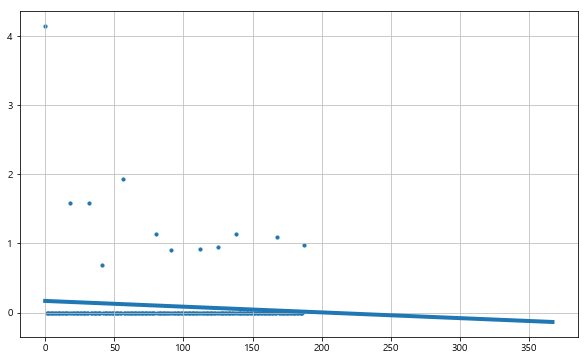

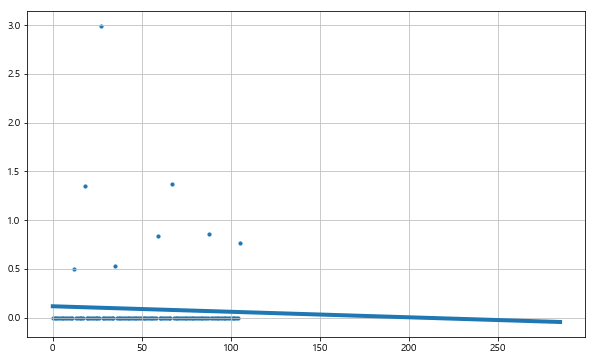

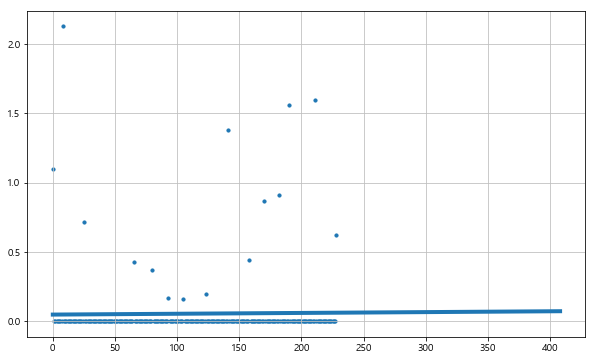

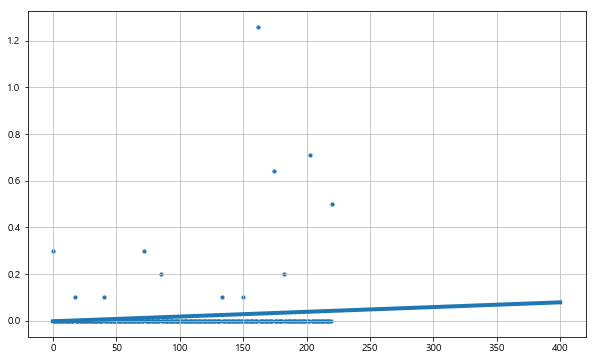

In [9]:
def 수요예측(rank, df2, _일자):
    df = pd.DataFrame({'ds':df2.index, 'y':df2['충전량']})
    df.reset_index(inplace=True)
    df['ds'] =  pd.to_datetime(df['ds'], format="%Y-%m-%d")
    del df['start']
    df=df.sort_values(by='ds')
    df.Timestamp = pd.to_datetime(df.ds,format='%d-%m-%Y %H:%M') 
    df.index = df.Timestamp 
    df = df.resample('D').sum()
    
    import numpy as np
    time = np.arange(0,len(df))
    y_value = df.y.values
    
    if (time[-1] <1):
        print ("충전내역 일수가 짧아 계싼 불가하여 예측을 생략합니다")
    else:
        fx = np.linspace(0,time[-1]+ _일자)
        fp1 = np.polyfit(time, y_value, 1)
        f1 = np.poly1d(fp1)
        
        plt.figure(figsize=(10,6))
        plt.scatter(time, y_value, s=10)
        plt.plot(fx, f1(fx), lw=4, label='f1')
        plt.grid(True, linestyle='-', color='0.75')
        plt.savefig(rf'그래프\수요예측_{상위권_이름[rank]}')
        print(예측하고싶은_일자, "일 후의 예상되는 일평균 충전량은", 상위권_이름[rank])
        print (f1(time[-1]+ _일자))
        
        def error(f,x,y):
            return np.sqrt(np.mean((f(x)-y)**2))
        print ("Square Mean Error:", error(f1,time,y_value))
        
충전소수 = len(충전이력['충전소명'].unique())
for i in range (0,충전소수):
    rank = i
    수요예측(rank,충전상위이력[rank], 예측하고싶은_일자)
    print('\n')

### 7.4 시간대별

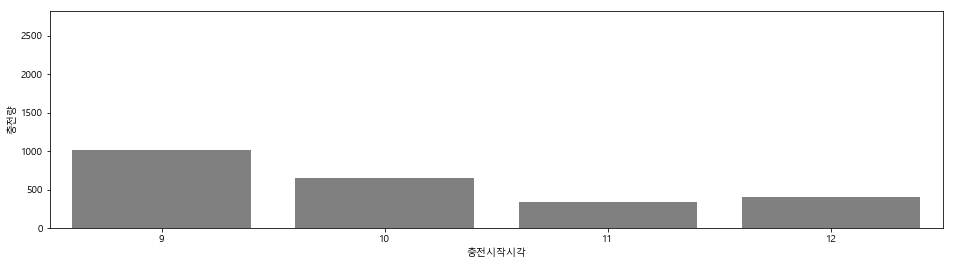

In [10]:
def 시간대별(rank, df):
    start = [] # 빈 리스트 생성
    end = []
    df_copy = df.copy()

    for i in range(len(df_copy.axes[0])):  # df의 행 갯수만큼 반복
        dtstart = df_copy.iloc[i,2]        # df의 1번째(실제는 두번째임, 파이썬은 0번째가 첫번째) 칼럼인 시작일시 칼럼
        start1 = int(dtstart.strftime("%H"))     
        start.append(start1)
    
    df_copy['충전시작시각'] = start

    df_temp = df_copy.groupby('충전시작시각')[['충전량']].sum()
    df_temp = df_temp.reset_index(drop=False)

    sns.set_palette("pastel")
    ax = sns.barplot(x='충전시작시각', y='충전량', data=df_temp,palette=['grey'])
    ax.figure.set_size_inches(16, 4)
    plt.savefig(rf'그래프\시간대별충전현황_{상위권_이름[rank]}')
    
충전소수 = len(충전이력['충전소명'].unique())
for i in range (0,충전소수):
    rank = i
    시간대별(rank,충전상위이력[rank])

### 7.5 요일별

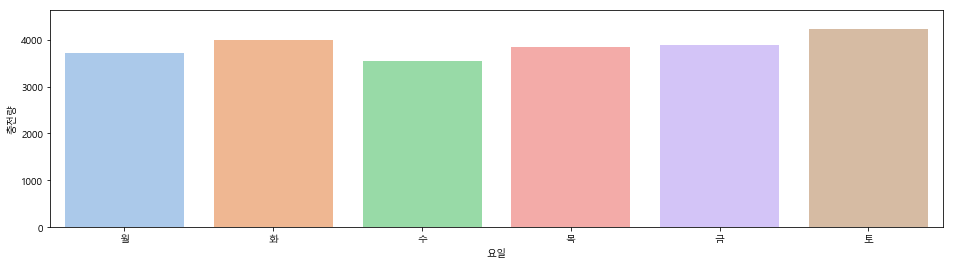

In [11]:
def 요일별(rank, df):
    df_copy = df.copy()
    
    df_copy['요일'] = df_copy['start'].dt.day_name()
    df_copy['숫자요일'] = df_copy['start'].dt.dayofweek
    df_temp = df_copy.groupby('숫자요일')[['충전량']].sum()
    df_temp = df_temp.reset_index(drop=False)
    
    label_text = ['월','화','수','목','금','토','일']
    ax = sns.barplot(x='숫자요일', y='충전량', data=df_temp)
    ax.set_xlabel('요일')
    ax.set_xticklabels(label_text)
    ax.figure.set_size_inches(16, 4)
    plt.savefig(rf'그래프\요일별충전현황_{상위권_이름[rank]}')
    
충전소수 = len(충전이력['충전소명'].unique())
for i in range (0,충전소수):
    rank = i
    요일별(rank,충전상위이력[rank])

### 7.6 월별

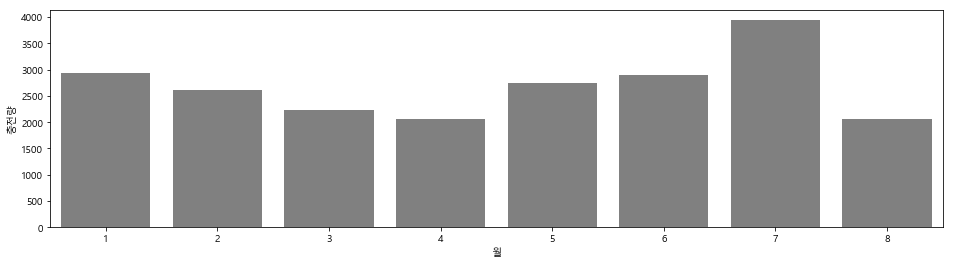

In [12]:
def 월별(rank, df):
    start = []
    end = []
    df_copy = df.copy()
    
    for i in range(len(df_copy.axes[0])):  # df의 행 갯수만큼 반복
        dtstart = df_copy.iloc[i,2]        # df의 1번째(실제는 두번째임, 파이썬은 0번째가 첫번째) 칼럼인 시작일시 칼럼
        start1 = int(dtstart.strftime("%m"))     
        start.append(start1)
        
    df_copy['월'] = start

    df_temp = df_copy.groupby('월')[['충전량']].sum().sort_values(by='월')
    df_temp = df_temp.reset_index(drop=False)

    ax = sns.barplot(x='월', y='충전량', data=df_temp,palette=['grey'])
    ax.figure.set_size_inches(16, 4)
    plt.savefig(rf'그래프\월별충전현황_{상위권_이름[rank]}')
    
충전소수 = len(충전이력['충전소명'].unique())
for i in range (0,충전소수):
    rank = i
    월별(rank,충전상위이력[rank])

### 본 프로그램 최종 수행후 생성된 충전량현황종합_전처리.csv 을 열어 다음 작업을 추가 
#### (1) 엑셀에서 맨 마지막에 "비고" 칼럼을 추가
#### (2) 아파트에 설치된 충전소는  "아파트"로 입력하고
#### (3) 아파트가 아닌 곳에 설치된 충전소는 "공공건물", "마트" 등과 같이 부합되는 내용으로 입력

The End